<a href="https://colab.research.google.com/github/OptimizationExpert/Pyomo/blob/main/ROGO_of_AddCircuit_Advanced_CP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip install ortools
from ortools.sat.python import cp_model # CP-SAT solver
import numpy as np
from random import randint
import random
from math import ceil
import pandas as pd
import matplotlib.pyplot as plt # Data visualization
#plt.rcParams["figure.figsize"] = (15,10)

In [38]:
matrix = [
    [5,  0,  0,  5,  0,  0,  4],
    [0,  8, -1,  0,  0, -1,  0],
    [0,  0,  2,  0,  0,  8,  0],
    [0, -1,  0,  4,  0,  0,  0],
    [4,  0,  2,  0,  2,  0,  5],
    [0,  0,  0,  5,  0, -1,  0],
    [0,  8,  0,  0,  8,  0,  0],
    [0, -1,  0,  0, -1,  4,  0],
    [5,  0,  0,  4,  0,  0,  2],
]
total = 20


matrix = [
    [4,  7,  0,  0,  0,  0,  3],
    [0,  0,  0,  0,  3,  0,  4],
    [0,  0,  4,  0,  7,  0,  0],
    [7,  0,  3,  0,  0,  0,  0],
    [-1, -1, -1, 0,  3,  0,  0],
    [-1, -1, 0,  7,  0,  0,  7],
    [-1, -1, 0,  0,  0,  4, -1],
    [-1, 4,  4,  0,  0,  0, -1],
    [-1, 0,  0,  0,  0,  3, -1],
    [0,  0,  3,  0,  4, -1, -1],
    [3,  0,  0,  0,  0, -1, -1],
    [7,  0,  7,  4, -1, -1, -1],
]
total = 16

matrix = [
    [4,  7,  0,  0,  0,  0,  3],   # Row 1
    [0,  0,  0,  0,  3,  0,  4],   # Row 2
    [0,  0,  4,  0,  7,  0,  0],   # Row 3
    [7,  0,  3,  0,  0,  0,  0],   # Row 4
    [-1, -1, -1, 0,  3,  0,  0],   # Row 5
    [-1, -1, 0,  7,  0,  0,  7],   # Row 6
    [-1, -1, 0,  0,  0,  4, -1],   # Row 7
    [-1,  4,  4,  0,  0,  0, -1],  # Row 8
    [-1,  0,  0,  0,  0,  3, -1],  # Row 9
    [0,  0,  3,  0,  4, -1, -1],   # Row 10
    [3,  0,  0,  0,  0, -1, -1],   # Row 11
    [7,  0,  7,  4, -1, -1, -1],   # Row 12
]
total = 16


cell_dict = {}
cell_number = 0
for i, row in enumerate(matrix):
    for j, value in enumerate(row):
        cell_dict[cell_number] = {'x': i, 'y': j, 'value': value}
        cell_number += 1

# Example: print the first 5 cells
for k in range(5):
    print(f"Cell {k}: {cell_dict[k]}")

Cell 0: {'x': 0, 'y': 0, 'value': 4}
Cell 1: {'x': 0, 'y': 1, 'value': 7}
Cell 2: {'x': 0, 'y': 2, 'value': 0}
Cell 3: {'x': 0, 'y': 3, 'value': 0}
Cell 4: {'x': 0, 'y': 4, 'value': 0}


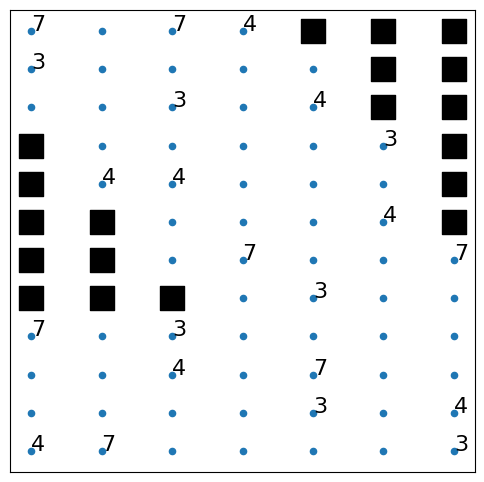

In [39]:
df = pd.DataFrame()
N = cell_number

nodes = [n for n in range(N)]
df['X'] = [cell_dict[n]['y'] for n in nodes]
df['Y'] = [cell_dict[n]['x'] for n in nodes]
df['V'] = [cell_dict[n]['value'] for n in nodes]



def dist(i,j,df):
  x1,y1 = df.loc[i,'X'],df.loc[i,'Y']
  x2,y2 = df.loc[j,'X'],df.loc[j,'Y']
  return int(1000*np.sqrt( (x1-x2)**2 +(y1-y2)**2))

plt.figure(figsize=(6,6))

plt.scatter(df['X'],df['Y'],s=20)
for n in nodes:
  x1,y1 = df.loc[n,'X'],df.loc[n,'Y']
  if df.loc[n,'V']<0:
    plt.scatter(x1,y1, s=300,color='k',marker='s')
  elif df.loc[n,'V']>0:
    plt.text(x1,y1, s=str(df.loc[n,'V']), fontsize=16)

plt.xticks([])
plt.yticks([])
plt.show()


allowed = [(i,j) for i in nodes for j in nodes if i!=j and abs(df.loc[i,'X']-df.loc[j,'X'])+ abs(df.loc[i,'Y']-df.loc[j,'Y'])<=1]


In [43]:
model = cp_model.CpModel()
solver = cp_model.CpSolver()

U = {(i,j):model.NewBoolVar(f"connection_{i}_{j}")  for (i,j) in allowed}

considered = {i:model.NewBoolVar(f"considered_{i}")  for i in nodes}

for i in nodes:
  if df.loc[i,'V']<0:
    considered[i]=False


arcs = [(i,j,v) for (i,j),v in U.items() ] +  [(i,i,v.Not()) for i,v in considered.items() if isinstance(v,cp_model.IntVar)] + [(i,i,True) for i,v in considered.items() if not isinstance(v,cp_model.IntVar)]
model.AddCircuit(arcs)

# Maximize x
expressions = [v for (i,j),v in U.items() ]
model.Add(sum(expressions) == total)

expressions_of = [v*df.loc[i,'V'] for i,v in considered.items() ]

model.Maximize(sum(expressions_of))
status = solver.Solve(model)
print(solver.ObjectiveValue())
print(f'Status = {solver.StatusName(status)}')
if status == cp_model.INFEASIBLE:
    print('SufficientAssumptionsForInfeasibility = '
          f'{solver.SufficientAssumptionsForInfeasibility()}')


36.0
Status = OPTIMAL


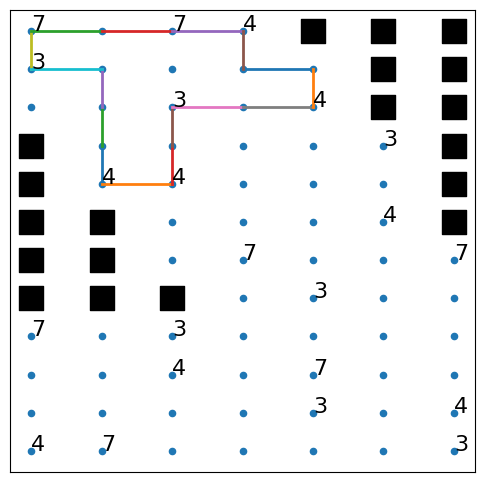

In [44]:
plt.figure(figsize=(6,6))

plt.scatter(df['X'],df['Y'],s=20)
for n in nodes:
  x1,y1 = df.loc[n,'X'],df.loc[n,'Y']
  if df.loc[n,'V']<0:
    plt.scatter(x1,y1, s=300,color='k',marker='s')
  elif df.loc[n,'V']>0:
    plt.text(x1,y1, s=str(df.loc[n,'V']), fontsize=16)

for (i,j),v in U.items():
  if solver.Value(v)>0:
    x1,y1 = df.loc[i,'X'],df.loc[i,'Y']
    x2,y2 = df.loc[j,'X'],df.loc[j,'Y']
    plt.plot([x1,x2],[y1,y2], lw= 2)
plt.xticks([])
plt.yticks([])
plt.show()